Before we start training process you should change runtime type.
1. Click to Runtime --> Change runtime type.
2. Choose "T4 GPU" and save it.

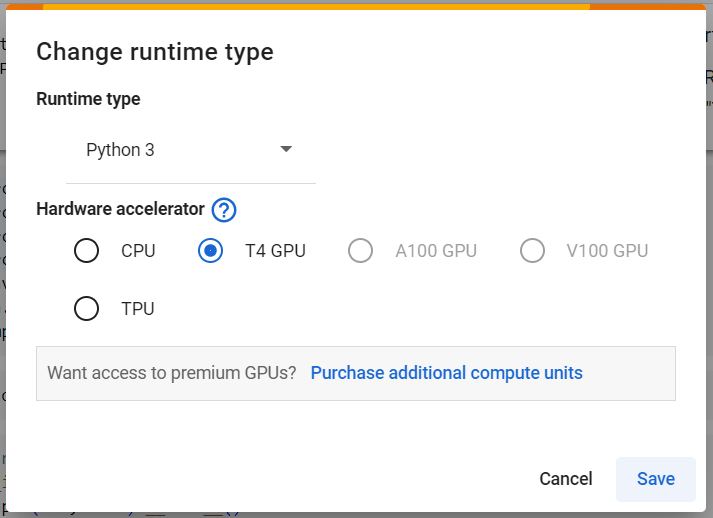

3. Upload test images to colab

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
import cv2
from matplotlib import pyplot as plt
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
batch_size = 128

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor()])

In [4]:

trainset = torchvision.datasets.CIFAR10(root='./cifar', train=True,
                                        download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=4)

testset = torchvision.datasets.CIFAR10(root='./cifar', train=False,
                                       download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=4)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Files already downloaded and verified


In [5]:
class ResNet50CustomInput(nn.Module):
    def __init__(self, num_classes, input_channels):
        super(ResNet50CustomInput, self).__init__()

        # Load the pre-trained ResNet-50 model without the final classification layer
        self.resnet = models.resnet50(pretrained=True)
        # Remove the original fully connected layer
        self.resnet = nn.Sequential(*list(self.resnet.children())[:-2])

        # Modify the first convolution layer to accept smaller input
        self.resnet[0] = nn.Conv2d(input_channels, 64, kernel_size=3, stride=1, padding=1, bias=False)

        # Adaptive average pooling layer to adapt to different input sizes
        self.avgpool = nn.AdaptiveAvgPool2d(1)

        # New fully connected layer for your specific number of classes
        self.fc = nn.Linear(2048, num_classes)

    def forward(self, x):
        x = self.resnet(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

# Instantiate the modified ResNet-50 model
num_classes = 10  # Adjust to your specific number of classes
input_channels = 3  # Adjust to match your input data channels
model = ResNet50CustomInput(num_classes, input_channels)
model = model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [7]:
def train(model, train_loader, optimizer, criterion, epoch):
    model.train()
    for batch_idx, data in enumerate(train_loader):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        output = model(inputs)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(inputs), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))


In [8]:
def test(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data in test_loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            output = model(inputs)
            test_loss += criterion(output, labels).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(labels.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset), accuracy))


In [9]:
epochs = 10
for epoch in range(1, epochs + 1):
    train(model, train_loader, optimizer, criterion, epoch)
    test(model, test_loader)
    torch.save(model.state_dict(), 'cifar_resnet50_model.pth')
    print('model saved')

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.447858
Train Epoch: 1 [12800/50000 (26%)]	Loss: 1.065620
Train Epoch: 1 [25600/50000 (51%)]	Loss: 0.776195
Train Epoch: 1 [38400/50000 (77%)]	Loss: 0.812170

Test set: Average loss: 0.0062, Accuracy: 7289/10000 (72.89%)

model saved
Train Epoch: 2 [0/50000 (0%)]	Loss: 0.634298
Train Epoch: 2 [12800/50000 (26%)]	Loss: 0.590312
Train Epoch: 2 [25600/50000 (51%)]	Loss: 0.682914
Train Epoch: 2 [38400/50000 (77%)]	Loss: 0.569270

Test set: Average loss: 0.0052, Accuracy: 7779/10000 (77.79%)

model saved
Train Epoch: 3 [0/50000 (0%)]	Loss: 0.347894
Train Epoch: 3 [12800/50000 (26%)]	Loss: 0.343605
Train Epoch: 3 [25600/50000 (51%)]	Loss: 0.353429
Train Epoch: 3 [38400/50000 (77%)]	Loss: 0.591068

Test set: Average loss: 0.0045, Accuracy: 8129/10000 (81.29%)

model saved
Train Epoch: 4 [0/50000 (0%)]	Loss: 0.191068
Train Epoch: 4 [12800/50000 (26%)]	Loss: 0.332339
Train Epoch: 4 [25600/50000 (51%)]	Loss: 0.288204
Train Epoch: 4 [38400/50000 (77%)]	Loss: 0

In [10]:
loaded_net = ResNet50CustomInput(num_classes, input_channels)
checkpoint = torch.load('cifar_resnet50_model.pth')
loaded_net.load_state_dict(checkpoint)
loaded_net = loaded_net.to(device)'

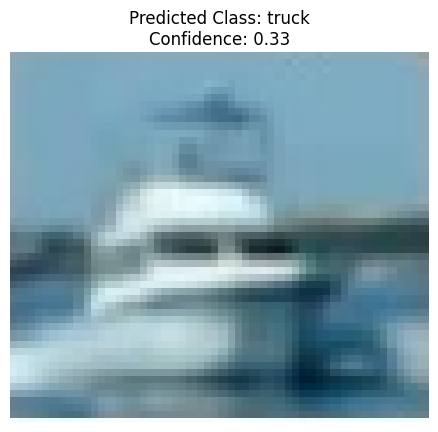

In [11]:
image = cv2.imread("cifar_img1.png")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
])

input_image = transform(image)
input_image = input_image.unsqueeze(0)
input_image = input_image.to(device)

with torch.no_grad():
    outputs = loaded_net(input_image)
_, predicted = torch.max(outputs, 1)

predicted_class = classes[predicted.item()]


confidence = torch.softmax(outputs, dim=1)[0][predicted.item()].item()

plt.imshow(image)
plt.title(f'Predicted Class: {predicted_class}\nConfidence: {confidence:.2f}')
plt.axis('off')
plt.show()

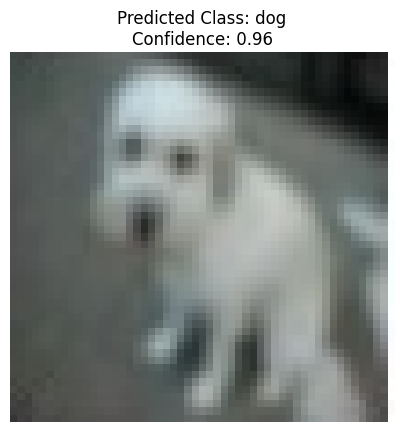

In [12]:
image = cv2.imread("cifar_img2.png")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((32, 32)),  # Resize the image to match the model's input size
    transforms.ToTensor(),
])

input_image = transform(image)
input_image = input_image.unsqueeze(0)  # Add a batch dimension
input_image = input_image.to(device)# Move the input to the GPU if available

with torch.no_grad():
    outputs = loaded_net(input_image)  # Unsqueeze to add batch dimension
_, predicted = torch.max(outputs, 1)


predicted_class = classes[predicted.item()]

# Get the prediction confidence
confidence = torch.softmax(outputs, dim=1)[0][predicted.item()].item()

# # Show the image and prediction
plt.imshow(image)
plt.title(f'Predicted Class: {predicted_class}\nConfidence: {confidence:.2f}')
plt.axis('off')
plt.show()

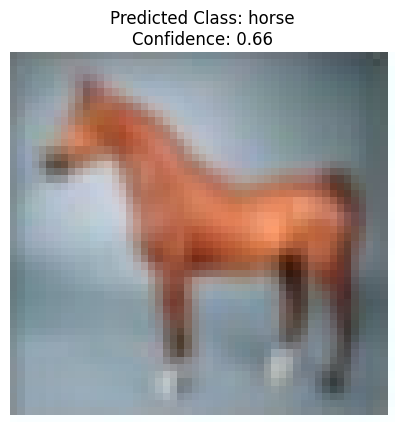

In [13]:
image = cv2.imread("cifar_img3.png")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((32, 32)),  # Resize the image to match the model's input size
    transforms.ToTensor(),
])

input_image = transform(image)
input_image = input_image.unsqueeze(0)  # Add a batch dimension
input_image = input_image.to(device)# Move the input to the GPU if available

with torch.no_grad():
    outputs = loaded_net(input_image)  # Unsqueeze to add batch dimension
_, predicted = torch.max(outputs, 1)

predicted_class = classes[predicted.item()]

# Get the prediction confidence
confidence = torch.softmax(outputs, dim=1)[0][predicted.item()].item()

# # Show the image and prediction
plt.imshow(image)
plt.title(f'Predicted Class: {predicted_class}\nConfidence: {confidence:.2f}')
plt.axis('off')
plt.show()